In [1]:
# ============================================================================
# NOTEBOOK 3: SENSITIVITY ANALYSIS OF DRAKE EQUATION
# ============================================================================
#
# This notebook performs comprehensive sensitivity analysis to understand 
# which parameters most influence N.
#
# We'll use:
# 1. Local Sensitivity: Partial derivatives and elasticities
# 2. Global Sensitivity: Sobol indices and variance decomposition
# 3. Morris Method: Elementary effects screening
# 4. Tornado Diagrams: Visual comparison of parameter impacts

# ============================================================================
# CELL 1: IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from drake.Parameters import BASELINE_PARAMS
from drake.Simulation import simulate_once
from drake.monte_carlo import run_monte_carlo

# For advanced sensitivity analysis (optional)
try:
    from SALib.sample import saltelli, morris
    from SALib.analyze import sobol, morris as morris_analyze
    SALIB_AVAILABLE = True
except ImportError:
    print("Warning: SALib not available. Install with: pip install SALib")
    SALIB_AVAILABLE = False

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# ============================================================================
# CELL 2: GENERATE BASELINE DATA (FIXED)
# ============================================================================

# Generate baseline Monte Carlo results
n_sims = 5000
mc_results = run_monte_carlo(BASELINE_PARAMS, n_simulations=n_sims)

# Extract data from the packed structure (same as notebook 1)
if isinstance(mc_results, pd.DataFrame):
    raw_results = mc_results['raw'].iloc[0] if hasattr(mc_results['raw'], 'iloc') else mc_results['raw'][0]
    N_values = mc_results['N'].iloc[0] if hasattr(mc_results['N'], 'iloc') else mc_results['N'][0]
elif isinstance(mc_results, dict):
    raw_results = mc_results['raw']
    N_values = mc_results['N']
else:
    raise ValueError(f"Unexpected mc_results type: {type(mc_results)}")

# Convert to DataFrame
df = pd.DataFrame(raw_results)

# Ensure N column exists
if 'N' not in df.columns:
    df['N'] = N_values

print(f"Generated {len(df):,} samples")
print(f"Parameters: {list(df.columns)}")

Generated 5,000 samples
Parameters: ['R_star', 'fp', 'ne', 'fl', 'fi', 'fc', 'L', 'N']


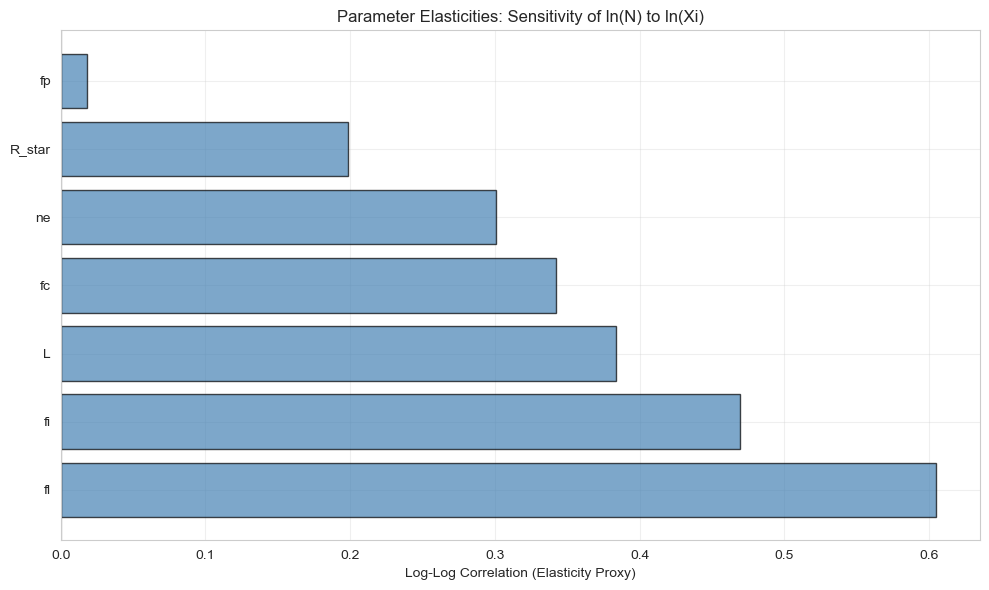


Elasticities (Log-Log Correlation):
fl         : +0.6050
fi         : +0.4695
L          : +0.3840
fc         : +0.3423
ne         : +0.3006
R_star     : +0.1987
fp         : +0.0183


In [5]:
# ============================================================================
# CELL 3: LOCAL SENSITIVITY - ELASTICITIES
# ============================================================================

# Log-log regression to estimate elasticities empirically
params = ['R_star', 'fp', 'ne', 'fl', 'fi', 'fc', 'L']

# Calculate log values (adding small constant to avoid log(0))
epsilon = 1e-10
log_df = np.log(df[params + ['N']] + epsilon)

# Calculate correlations in log space (proxy for elasticity)
elasticities = {}
for param in params:
    correlation = log_df[param].corr(log_df['N'])
    elasticities[param] = correlation

# Plot elasticities
fig, ax = plt.subplots(figsize=(10, 6))
sorted_params = sorted(elasticities.items(), key=lambda x: abs(x[1]), reverse=True)
param_names = [p[0] for p in sorted_params]
param_values = [p[1] for p in sorted_params]

colors = ['red' if v < 0 else 'steelblue' for v in param_values]
ax.barh(param_names, param_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Log-Log Correlation (Elasticity Proxy)')
ax.set_title('Parameter Elasticities: Sensitivity of ln(N) to ln(Xi)')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nElasticities (Log-Log Correlation):")
print("="*50)
for param, value in sorted_params:
    print(f"{param:10} : {value:+.4f}")

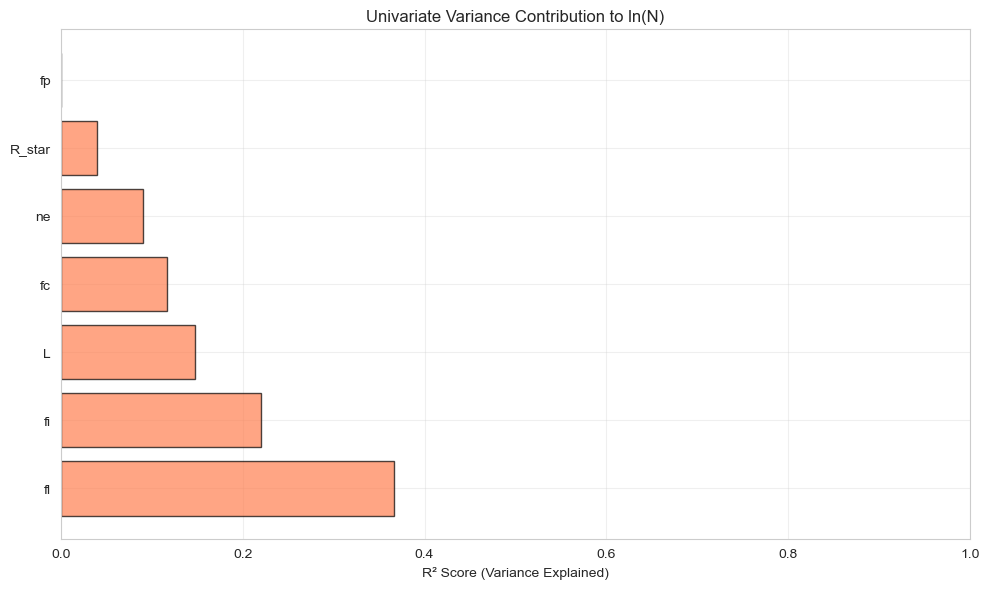


Variance Contribution (R²):
fl         : 0.3660 (36.60% variance explained)
fi         : 0.2204 (22.04% variance explained)
L          : 0.1474 (14.74% variance explained)
fc         : 0.1172 (11.72% variance explained)
ne         : 0.0904 (9.04% variance explained)
R_star     : 0.0395 (3.95% variance explained)
fp         : 0.0003 (0.03% variance explained)


In [7]:
# ============================================================================
# CELL 4: VARIANCE-BASED SENSITIVITY
# ============================================================================

# Calculate partial variances using regression
from sklearn.linear_model import LinearRegression

# Use log-transformed data for better linearity
X = log_df[params].values
y = log_df['N'].values

# Fit model
model = LinearRegression()
model.fit(X, y)

# Calculate R² for each parameter individually
r2_scores = {}
for i, param in enumerate(params):
    X_single = X[:, i].reshape(-1, 1)
    model_single = LinearRegression()
    model_single.fit(X_single, y)
    r2_scores[param] = model_single.score(X_single, y)

# Plot R² scores
fig, ax = plt.subplots(figsize=(10, 6))
sorted_r2 = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)
param_names = [p[0] for p in sorted_r2]
r2_values = [p[1] for p in sorted_r2]

ax.barh(param_names, r2_values, color='coral', alpha=0.7, edgecolor='black')
ax.set_xlabel('R² Score (Variance Explained)')
ax.set_title('Univariate Variance Contribution to ln(N)')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVariance Contribution (R²):")
print("="*50)
for param, value in sorted_r2:
    print(f"{param:10} : {value:.4f} ({value*100:.2f}% variance explained)")

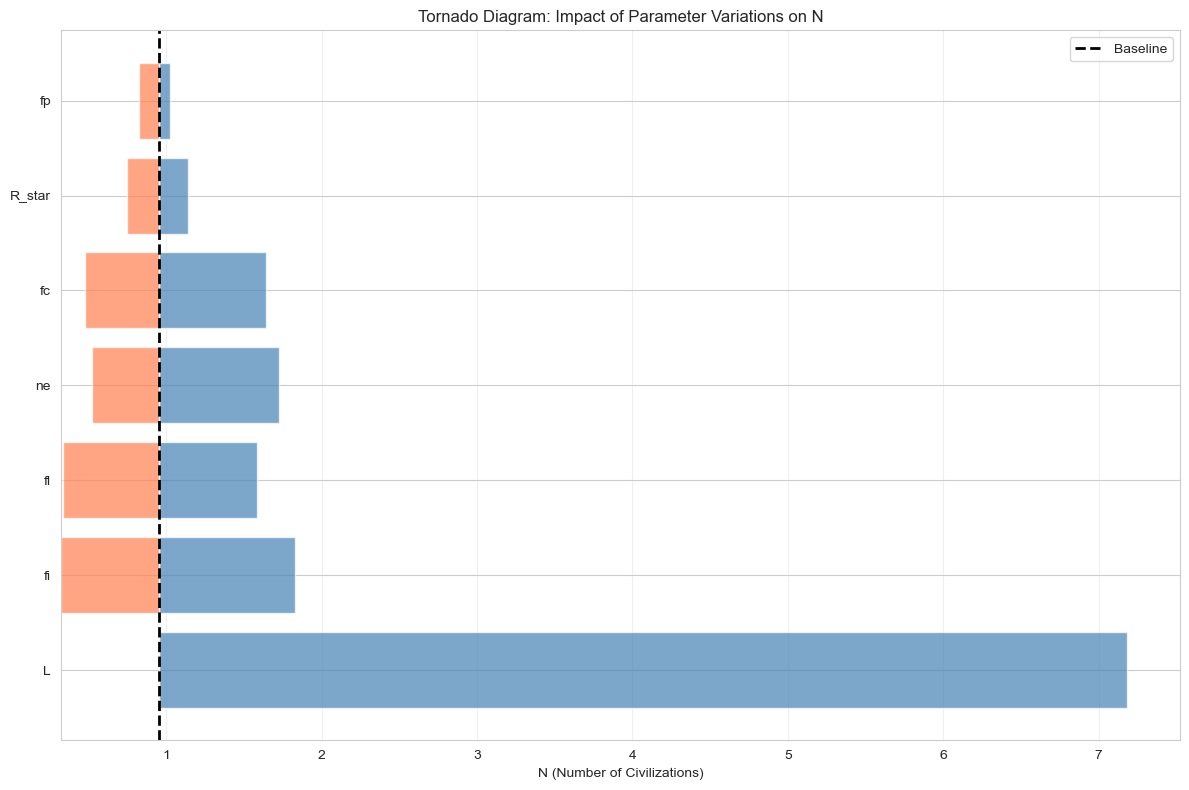


Tornado Analysis Results:
Baseline N: 0.95

Parameter Swings (sorted by impact):
L          : Low=    0.95, High=    7.18, Swing=    6.23
fi         : Low=    0.32, High=    1.83, Swing=    1.51
fl         : Low=    0.34, High=    1.58, Swing=    1.25
ne         : Low=    0.53, High=    1.73, Swing=    1.20
fc         : Low=    0.48, High=    1.64, Swing=    1.17
R_star     : Low=    0.75, High=    1.14, Swing=    0.40
fp         : Low=    0.82, High=    1.03, Swing=    0.21


In [8]:
# ============================================================================
# CELL 5: TORNADO DIAGRAM
# ============================================================================

def calculate_tornado_values(df, params, output='N'):
    """Calculate high/low values for tornado diagram."""
    baseline = df[output].mean()
    ranges = {}
    
    for param in params:
        mean = df[param].mean()
        std = df[param].std()
        
        # High: param at mean+std, others at their means
        high_mask = df[param] > (mean + 0.5 * std)
        high_val = df.loc[high_mask, output].mean() if high_mask.sum() > 0 else baseline
        
        # Low: param at mean-std, others at their means  
        low_mask = df[param] < (mean - 0.5 * std)
        low_val = df.loc[low_mask, output].mean() if low_mask.sum() > 0 else baseline
        
        ranges[param] = {'low': low_val, 'high': high_val, 'swing': abs(high_val - low_val)}
    
    return baseline, ranges

baseline_N, tornado_ranges = calculate_tornado_values(df, params)

# Sort by swing (impact)
sorted_tornado = sorted(tornado_ranges.items(), key=lambda x: x[1]['swing'], reverse=True)

# Create tornado diagram
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(sorted_tornado))
param_names = [p[0] for p in sorted_tornado]

for i, (param, values) in enumerate(sorted_tornado):
    low = values['low']
    high = values['high']
    
    # Plot bars
    ax.barh(i, high - baseline_N, left=baseline_N, 
            color='steelblue', alpha=0.7, height=0.8)
    ax.barh(i, baseline_N - low, left=low, 
            color='coral', alpha=0.7, height=0.8)

ax.axvline(baseline_N, color='black', linewidth=2, linestyle='--', label='Baseline')
ax.set_yticks(y_pos)
ax.set_yticklabels(param_names)
ax.set_xlabel('N (Number of Civilizations)')
ax.set_title('Tornado Diagram: Impact of Parameter Variations on N')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTornado Analysis Results:")
print("="*70)
print(f"Baseline N: {baseline_N:.2f}")
print("\nParameter Swings (sorted by impact):")
for param, values in sorted_tornado:
    print(f"{param:10} : Low={values['low']:8.2f}, High={values['high']:8.2f}, Swing={values['swing']:8.2f}")

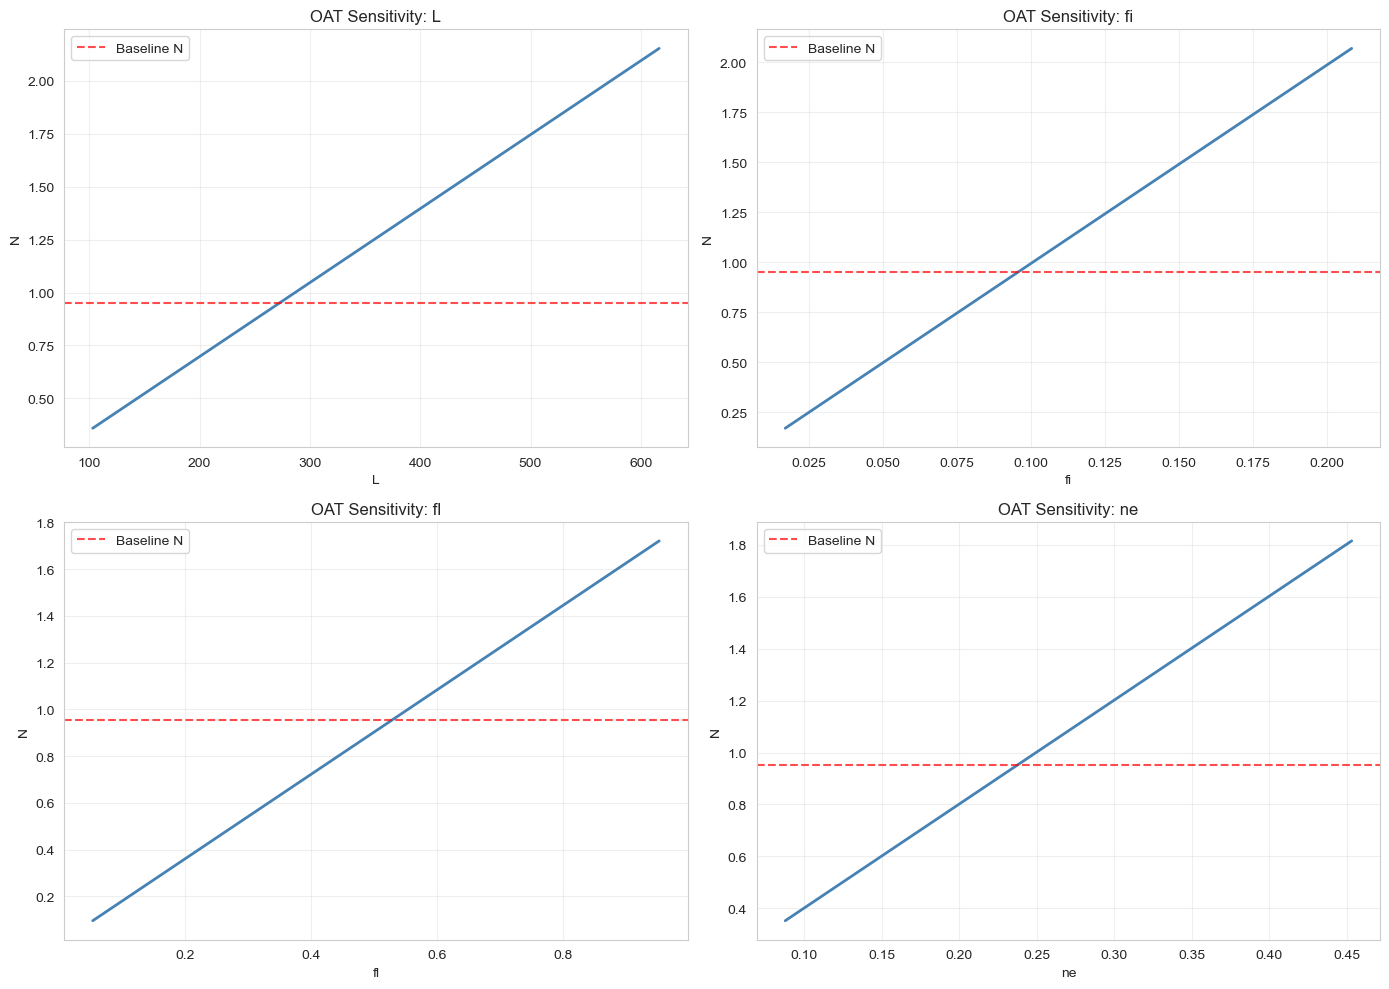

In [9]:
# ============================================================================
# CELL 6: ONE-AT-A-TIME (OAT) SENSITIVITY
# ============================================================================

# Vary each parameter while holding others at their mean
def oat_analysis(df, param_to_vary, n_points=20):
    """One-at-a-time sensitivity analysis."""
    param_range = np.linspace(
        df[param_to_vary].quantile(0.05),
        df[param_to_vary].quantile(0.95),
        n_points
    )
    
    # Calculate N for each value
    N_values = []
    for val in param_range:
        # Calculate N with this parameter value and means for others
        N = val
        for other_param in params:
            if other_param != param_to_vary:
                N *= df[other_param].mean()
        N_values.append(N)
    
    return param_range, N_values

# Plot OAT for top 4 parameters
top_params = [p[0] for p in sorted_tornado[:4]]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, param in enumerate(top_params):
    param_range, N_values = oat_analysis(df, param)
    
    axes[idx].plot(param_range, N_values, linewidth=2, color='steelblue')
    axes[idx].axhline(baseline_N, color='red', linestyle='--', alpha=0.7, label='Baseline N')
    axes[idx].set_xlabel(param)
    axes[idx].set_ylabel('N')
    axes[idx].set_title(f'OAT Sensitivity: {param}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.show()

C:\Users\rfull\AppData\Local\Temp\ipykernel_26060\705891785.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 512)  # 512 * (2*7 + 2) = ~8K samples


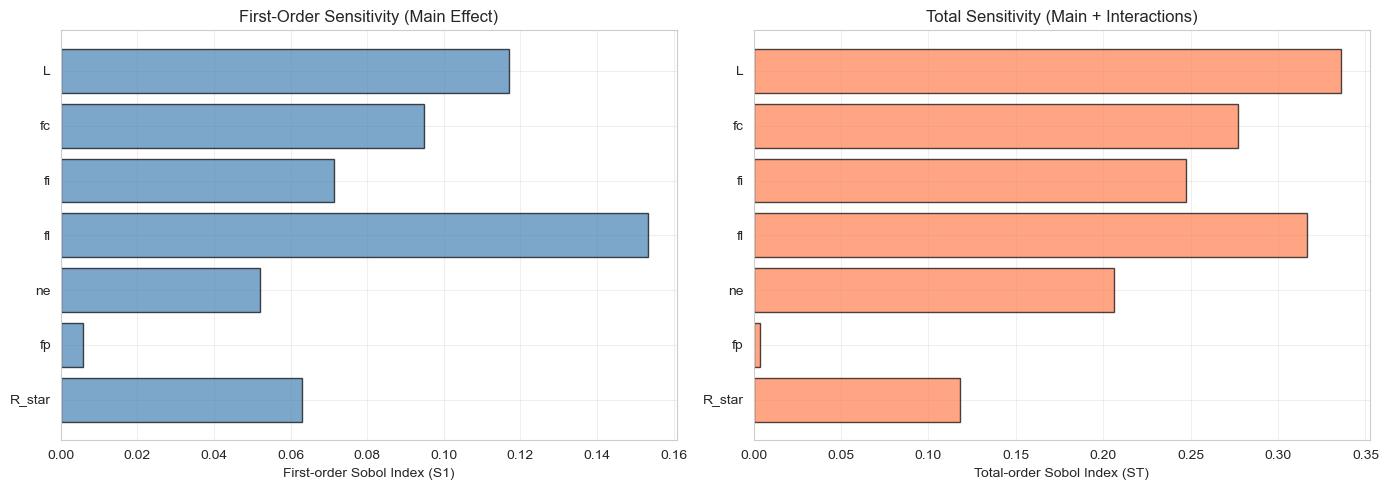


Sobol Indices:
Parameter  S1 (First)      ST (Total)      Interaction
----------------------------------------------------------------------
R_star           0.0629          0.1182          0.0553
fp               0.0059          0.0039         -0.0020
ne               0.0520          0.2061          0.1541
fl               0.1533          0.3164          0.1630
fi               0.0714          0.2473          0.1759
fc               0.0948          0.2768          0.1820
L                0.1170          0.3359          0.2189


In [11]:
# ============================================================================
# CELL 7: SOBOL SENSITIVITY INDICES (if SALib available)
# ============================================================================

if SALIB_AVAILABLE:
    # Define problem for SALib
    problem = {
        'num_vars': len(params),
        'names': params,
        'bounds': [[df[p].min(), df[p].max()] for p in params]
    }
    
    # Generate samples
    param_values = saltelli.sample(problem, 512)  # 512 * (2*7 + 2) = ~8K samples
    
    # Evaluate model
    Y = np.zeros(len(param_values))
    for i, vals in enumerate(param_values):
        Y[i] = np.prod(vals)  # Drake equation is just the product
    
    # Analyze
    Si = sobol.analyze(problem, Y)
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # First-order indices
    axes[0].barh(params, Si['S1'], color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('First-order Sobol Index (S1)')
    axes[0].set_title('First-Order Sensitivity (Main Effect)')
    axes[0].grid(True, alpha=0.3)
    
    # Total-order indices
    axes[1].barh(params, Si['ST'], color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Total-order Sobol Index (ST)')
    axes[1].set_title('Total Sensitivity (Main + Interactions)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSobol Indices:")
    print("="*70)
    print(f"{'Parameter':<10} {'S1 (First)':<15} {'ST (Total)':<15} {'Interaction'}")
    print("-"*70)
    for i, param in enumerate(params):
        interaction = Si['ST'][i] - Si['S1'][i]
        print(f"{param:<10} {Si['S1'][i]:>12.4f}    {Si['ST'][i]:>12.4f}    {interaction:>12.4f}")
else:
    print("SALib not available. Install with: pip install SALib")

In [12]:
# ============================================================================
# CELL 8: PARAMETER RANKING SUMMARY
# ============================================================================

# Create summary table
summary_data = []
for param in params:
    row = {
        'Parameter': param,
        'Elasticity': elasticities[param],
        'R² Score': r2_scores[param],
        'Tornado Swing': tornado_ranges[param]['swing']
    }
    if SALIB_AVAILABLE:
        idx = params.index(param)
        row['Sobol S1'] = Si['S1'][idx]
        row['Sobol ST'] = Si['ST'][idx]
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('R² Score', ascending=False)

print("\n" + "="*80)
print("COMPREHENSIVE SENSITIVITY SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("\n" + "="*80)

# Save to CSV
summary_df.to_csv('sensitivity_summary.csv', index=False)
print("\n✓ Sensitivity summary saved to 'sensitivity_summary.csv'")


COMPREHENSIVE SENSITIVITY SUMMARY
Parameter  Elasticity  R² Score  Tornado Swing  Sobol S1  Sobol ST
       fl    0.604972  0.365991       1.245348  0.153340  0.316356
       fi    0.469492  0.220422       1.509399  0.071358  0.247281
        L    0.383954  0.147420       6.227791  0.116995  0.335941
       fc    0.342310  0.117176       1.165614  0.094846  0.276817
       ne    0.300622  0.090374       1.201872  0.052033  0.206142
   R_star    0.198688  0.039477       0.395220  0.062873  0.118217
       fp    0.018291  0.000335       0.205300  0.005942  0.003947


✓ Sensitivity summary saved to 'sensitivity_summary.csv'
